In [0]:
import numpy as np 
import pandas as pd
import cv2
import glob
from cv2 import normalize as normalize
from matplotlib import pyplot as plt
from IPython.display import HTML, display
import time
from tqdm import tqdm_notebook as tqdm
import scipy.misc
from google.colab.patches import cv2_imshow
from __future__ import print_function
from numpy import linspace
from mpl_toolkits.mplot3d import Axes3D

In [0]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('/content/imgs/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        print(fname)
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners2,ret)
        #cv2_imshow(img)

/content/imgs/WIN_20190911_17_46_39_Pro.jpg
/content/imgs/WIN_20190911_17_47_25_Pro.jpg
/content/imgs/WIN_20190911_17_47_06_Pro.jpg
/content/imgs/WIN_20190911_17_46_50_Pro.jpg
/content/imgs/WIN_20190911_17_47_12_Pro.jpg
/content/imgs/WIN_20190911_17_47_08_Pro.jpg
/content/imgs/WIN_20190911_17_47_09_Pro.jpg
/content/imgs/WIN_20190911_17_46_44_Pro.jpg
/content/imgs/WIN_20190911_17_47_14_Pro.jpg
/content/imgs/WIN_20190911_17_46_54_Pro.jpg
/content/imgs/WIN_20190911_17_47_22_Pro.jpg
/content/imgs/WIN_20190911_17_47_17_Pro.jpg
/content/imgs/WIN_20190911_17_46_52_Pro.jpg
/content/imgs/WIN_20190911_17_47_16_Pro.jpg
/content/imgs/WIN_20190911_17_47_02_Pro.jpg
/content/imgs/WIN_20190911_17_47_00_Pro.jpg
/content/imgs/WIN_20190911_17_46_57_Pro.jpg
/content/imgs/WIN_20190911_17_47_19_Pro.jpg
/content/imgs/WIN_20190911_17_46_41_Pro.jpg
/content/imgs/WIN_20190911_17_47_10_Pro.jpg


In [0]:
rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [0]:
print(np.asarray(rvecs).shape,np.asarray(tvecs).shape)
print(np.asarray(objpoints).shape,np.asarray(imgpoints).shape)

(20, 3, 1) (20, 3, 1)
(20, 54, 3) (20, 54, 1, 2)


In [0]:
    print("RMS:", rms)
    print("camera matrix:\n", camera_matrix)
    print("distortion coefficients: ", dist_coefs.ravel())

RMS: 0.3921989703575788
camera matrix:
 [[544.7639419    0.         318.40645859]
 [  0.         549.36438592 218.25462863]
 [  0.           0.           1.        ]]
distortion coefficients:  [ 0.11896198 -0.1175462  -0.00837272 -0.00290169 -0.20175268]


In [0]:
def inverse_homogeneoux_matrix(M):
    R = M[0:3, 0:3]
    T = M[0:3, 3]
    M_inv = np.identity(4)
    M_inv[0:3, 0:3] = R.T
    M_inv[0:3, 3] = -(R.T).dot(T)

    return M_inv

def transform_to_matplotlib_frame(cMo, X, inverse=False):
    M = np.identity(4)
    M[1,1] = 0
    M[1,2] = 1
    M[2,1] = -1
    M[2,2] = 0

    if inverse:
        return M.dot(inverse_homogeneoux_matrix(cMo).dot(X))
    else:
        return M.dot(cMo.dot(X))

In [0]:
def create_camera_model(camera_matrix, width, height, scale_focal, draw_frame_axis=False):
    fx = camera_matrix[0,0]
    fy = camera_matrix[1,1]
    focal = 2 / (fx + fy)
    f_scale = scale_focal * focal

    # draw image plane
    X_img_plane = np.ones((4,5))
    X_img_plane[0:3,0] = [-width, height, f_scale]
    X_img_plane[0:3,1] = [width, height, f_scale]
    X_img_plane[0:3,2] = [width, -height, f_scale]
    X_img_plane[0:3,3] = [-width, -height, f_scale]
    X_img_plane[0:3,4] = [-width, height, f_scale]

    # draw triangle above the image plane
    X_triangle = np.ones((4,3))
    X_triangle[0:3,0] = [-width, -height, f_scale]
    X_triangle[0:3,1] = [0, -2*height, f_scale]
    X_triangle[0:3,2] = [width, -height, f_scale]

    # draw camera
    X_center1 = np.ones((4,2))
    X_center1[0:3,0] = [0, 0, 0]
    X_center1[0:3,1] = [-width, height, f_scale]

    X_center2 = np.ones((4,2))
    X_center2[0:3,0] = [0, 0, 0]
    X_center2[0:3,1] = [width, height, f_scale]

    X_center3 = np.ones((4,2))
    X_center3[0:3,0] = [0, 0, 0]
    X_center3[0:3,1] = [width, -height, f_scale]

    X_center4 = np.ones((4,2))
    X_center4[0:3,0] = [0, 0, 0]
    X_center4[0:3,1] = [-width, -height, f_scale]

    # draw camera frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [f_scale/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, f_scale/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, f_scale/2]

    if draw_frame_axis:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4, X_frame1, X_frame2, X_frame3]
    else:
        return [X_img_plane, X_triangle, X_center1, X_center2, X_center3, X_center4]

In [0]:
def create_board_model(extrinsics, board_width, board_height, square_size, draw_frame_axis=False):
    width = board_width*square_size
    height = board_height*square_size

    # draw calibration board
    X_board = np.ones((4,5))
    #X_board_cam = np.ones((extrinsics.shape[0],4,5))
    X_board[0:3,0] = [0,0,0]
    X_board[0:3,1] = [width,0,0]
    X_board[0:3,2] = [width,height,0]
    X_board[0:3,3] = [0,height,0]
    X_board[0:3,4] = [0,0,0]

    # draw board frame axis
    X_frame1 = np.ones((4,2))
    X_frame1[0:3,0] = [0, 0, 0]
    X_frame1[0:3,1] = [height/2, 0, 0]

    X_frame2 = np.ones((4,2))
    X_frame2[0:3,0] = [0, 0, 0]
    X_frame2[0:3,1] = [0, height/2, 0]

    X_frame3 = np.ones((4,2))
    X_frame3[0:3,0] = [0, 0, 0]
    X_frame3[0:3,1] = [0, 0, height/2]

    if draw_frame_axis:
        return [X_board, X_frame1, X_frame2, X_frame3]
    else:
        return [X_board]

In [0]:
def draw_camera_boards(ax, camera_matrix, cam_width, cam_height, scale_focal,
                       extrinsics, board_width, board_height, square_size,
                       patternCentric):
    from matplotlib import cm

    min_values = np.zeros((3,1))
    min_values = np.inf
    max_values = np.zeros((3,1))
    max_values = -np.inf

    if patternCentric:
        X_moving = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal)
        X_static = create_board_model(extrinsics, board_width, board_height, square_size)
    else:
        X_static = create_camera_model(camera_matrix, cam_width, cam_height, scale_focal, True)
        X_moving = create_board_model(extrinsics, board_width, board_height, square_size)

    cm_subsection = linspace(0.0, 1.0, extrinsics.shape[0])
    colors = [ cm.jet(x) for x in cm_subsection ]

    for i in range(len(X_static)):
        X = np.zeros(X_static[i].shape)
        for j in range(X_static[i].shape[1]):
            X[:,j] = transform_to_matplotlib_frame(np.eye(4), X_static[i][:,j])
        ax.plot3D(X[0,:], X[1,:], X[2,:], color='r')
        min_values = np.minimum(min_values, X[0:3,:].min(1))
        max_values = np.maximum(max_values, X[0:3,:].max(1))

    for idx in range(extrinsics.shape[0]):
        R, _ = cv2.Rodrigues(extrinsics[idx,0:3])
        cMo = np.eye(4,4)
        cMo[0:3,0:3] = R
        cMo[0:3,3] = extrinsics[idx,3:6]
        for i in range(len(X_moving)):
            X = np.zeros(X_moving[i].shape)
            for j in range(X_moving[i].shape[1]):
                X[0:4,j] = transform_to_matplotlib_frame(cMo, X_moving[i][0:4,j], patternCentric)
            ax.plot3D(X[0,:], X[1,:], X[2,:], color=colors[idx])
            min_values = np.minimum(min_values, X[0:3,:].min(1))
            max_values = np.maximum(max_values, X[0:3,:].max(1))

    return min_values, max_values

In [0]:
    print("RMS:", rms)
    print("camera matrix:\n", camera_matrix)
    print("distortion coefficients: ", dist_coefs.ravel())

RMS: 0.3921989703575788
camera matrix:
 [[544.7639419    0.         318.40645859]
 [  0.         549.36438592 218.25462863]
 [  0.           0.           1.        ]]
distortion coefficients:  [ 0.11896198 -0.1175462  -0.00837272 -0.00290169 -0.20175268]


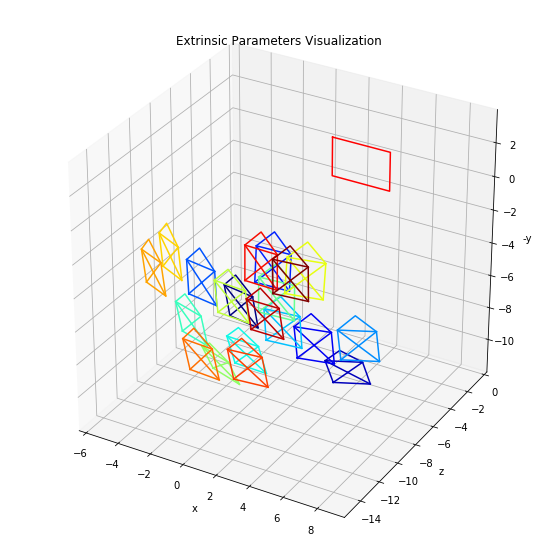

Done


In [0]:
cam_width = 0.064/2
cam_height = 0.048/2
scale_focal = 40
patternCentric = True
board_width = 9
board_height = 6
square_size = rms
camera_matrix = camera_matrix
extrinsics = []
for rv,tv in zip(rvecs,tvecs):
    extrinsics.append(np.append(rv.flatten(),tv.flatten()))
extrinsics = np.asarray(extrinsics)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
cam_width = 1
cam_height = 1
scale_focal = rms
min_values, max_values = draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                            scale_focal, extrinsics, board_width,
                                            board_height, square_size, patternCentric)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0
mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()
print('Done')

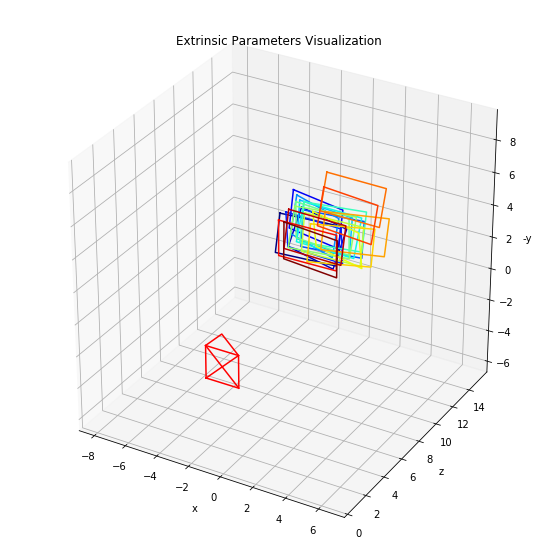

Done


In [0]:
cam_width = 0.064/2
cam_height = 0.048/2
scale_focal = 40
patternCentric = False
board_width = 9
board_height = 6
square_size = rms
camera_matrix = camera_matrix
extrinsics = []
for rv,tv in zip(rvecs,tvecs):
    extrinsics.append(np.append(rv.flatten(),tv.flatten()))
extrinsics = np.asarray(extrinsics)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.set_aspect("equal")
cam_width = 1
cam_height = 1
scale_focal = rms
min_values, max_values = draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                            scale_focal, extrinsics, board_width,
                                            board_height, square_size, patternCentric)
X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0
mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()
print('Done')